# Import libraries

In [1]:
# Python libraries
import os
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Using ipynb import functions defined in other nb
from ipynb.fs.defs.myfun_load_dataset import *
from ipynb.fs.defs.myfun_models import *
# from ipynb.fs.full.myfun_plot import *

pandas: 1.5.3
numpy: 1.23.5


2023-08-15 18:05:15.858423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Acquisition

In [2]:
# Load the dataset
par_dir = os.path.dirname(os.getcwd()) # parent dir
dir_name = par_dir + "/NN-interaction"
merged_df, dflist = load_dataset(dir_name, 'post') # we have 10 pandas dataframe, one for each couple(camera,sequence)

> **WARNING:**
> I have to standardize the data?

# Train and Evaluate a Neural Network

## Step 1: Select data for modeling

* X will be the consective distances btw vehicles
* y will be the approximated velocity

In [3]:
# For sake of simplicity conseder only a scene
df = dflist[0] # fix a sequence
scn = df.T[0]  # fix a scene

In [4]:
scn

Tarr           [9.440000000000001, 9.64, 9.840000000000002, 1...
Xarr           [[29.373325674060805, 34.22142942994519, 38.50...
Cons Dis       [[28.985128254938463, 28.827356057195246, 29.0...
N. vehicles                                                    3
cam                                                            1
day                                                            1
seq                                                            1
N. file                                                        1
Name: 0, dtype: object

### Create X

In [5]:
X = scn['Cons Dis'][:,0] # consecutive distances btw vehicles at initial time
X

array([28.98512825,  1.78659013])

### Create y

In [6]:
dX_arr = np.diff(scn['Xarr'],axis=1)
dT_arr = np.diff(scn['Tarr'])
y_arr = dX_arr/dT_arr # velocity at the timestamps
y_arr

array([[  24.24051878,   21.42551813,   25.90595108,  -20.76701156,
          17.2505642 ],
       [  23.45165779,   22.56197993,   28.20275155, -120.54398325,
          36.80699865],
       [  26.96201742,   26.07238731,   38.06411685,    5.39850737,
          35.72984852]])

In [7]:
# we choose the first velocity discretized as (x_(i+1)-x_i)/deltaT
y_arr_0 = y_arr[:,0]
y = y_arr_0[:-1] #drop the last one
y

array([24.24051878, 23.45165779])

### Comparing trajectories of our scene and the one using the velocity in y

#### Computing trajs using the velocity in y

In [8]:
# time discretization
tstamps = scn['Tarr']                              # timestamps scene
deltat = 0.05                                      # timestep for our ODE, factor to match timestep of data
Nt = int((tstamps[-1]-tstamps[0])/deltat) + 1      # number of discretization points (we need to cast the value)
tspan = np.linspace(tstamps[0], tstamps[-1], Nt)   # timespan

# space
N = scn['N. vehicles']  # numbers of vehicles
x0 =  scn['Xarr'][:,0]  # initial condition

In [9]:
# To recover the same timestep in the data
factor = int(0.2/deltat)

if len(set(tstamps - tspan[::factor])) == 1:
    print(f"timestamps coincide!")
    print("* tstamps: \t\t", tstamps,\
          "\n* tspan[::,factor]: \t",tspan[::factor])
else:
    print(f"There is a mismatch in the timestamps: tstamps != tspan[::factor]")

timestamps coincide!
* tstamps: 		 [ 9.44  9.64  9.84 10.04 10.24 10.44] 
* tspan[::,factor]: 	 [ 9.44  9.64  9.84 10.04 10.24 10.44]


In [10]:
# For a single argument do not forget to add the comma in the tuple e.g.
v0 = 30
vel = np.append(y,v0) 
sol = odeint(TD_ANN_model, x0, tspan, args=(vel,), tfirst = True).T
sol_matched = sol[:,::factor] # match the sol in the same timestamps as data

In [11]:
# tspan_ann, sol_ann = odesolver_ann(x0,vel,tstamps[0],tstamps[-1], tout="end", deltat = 0.05)
# sol_ann[:,::factor] == sol_matched

#### Plot

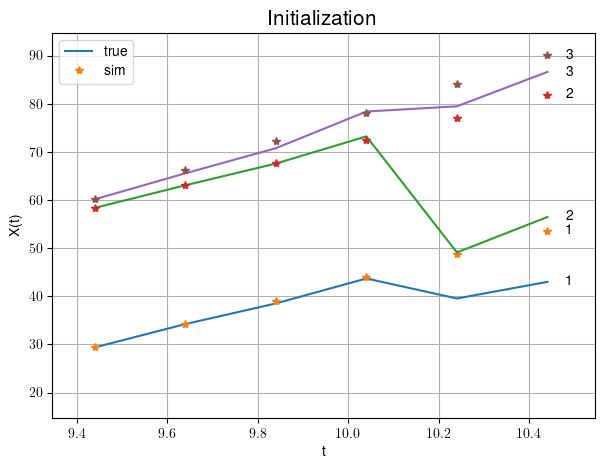

In [12]:
# Params
N = scn['N. vehicles']
t0, tf = tstamps[0], tstamps[-1]
trajs = [scn['Xarr'],sol_matched]
labels_plot = ["true", "sim"]
title = f"Initialization"

# fig 
width, height = 7, 5
fig, ax = plt.subplots(figsize=(width,height))

for veh in range(0,N):
    ax.plot(tstamps, trajs[0][veh])
    ax.plot(tspan[::factor], trajs[1][veh], '*')

# Annotate the name of each variable at the last value
scale = 1.004
labels = list(range(1,N+1,1))
for ycoord in trajs:
    coords = zip([tf*scale]*N,ycoord[:,-1]) # last value where I want to annotate the corresponding label
    for coord,lab in zip(coords,labels):
        ax.annotate(xy=coord,                    # The point (x, y) to annotate.
                    xytext=coord,                # The position (x, y) to place the text at.
    #                 textcoords='offset points',
                    text=lab,
                    verticalalignment='center')

ax.set_xlabel("t")
ax.set_ylabel("X(t)")
ax.set_title(title, fontsize=15)
# X LIM
xbal = 0.01
ax.set_xlim(tstamps[0]*(1-xbal), tstamps[-1]*(1+xbal))
# Y LIM
ybal = 0.05
mmin, mmax = min([x.min() for x in trajs]), max([x.max() for x in trajs])
ax.set_ylim(mmin*(1-10*ybal), mmax*(1+ybal))
plt.legend(labels_plot)
plt.grid()
plt.show()

In [13]:
scn['Xarr']

array([[29.37332567, 34.22142943, 38.50653306, 43.68772327, 39.53432096,
        42.9844338 ],
       [58.35845393, 63.04878549, 67.56118147, 73.20173178, 49.09293513,
        56.45433487],
       [60.14504406, 65.53744755, 70.75192501, 78.36474838, 79.44444985,
        86.59041956]])

> !**Warning**: macchinina 2 true impazzita

## Step 2: Create training and testing samples

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

> !**WARNING**:\
> It doesn't make sense t split X and y\
> to add randomness we need to choose a particular sequence instead of all the dataset?

## Step 3: Specify the structure of a Neural Network (1-2-1)

In [15]:
DOE =[[1,2,1]] #Design of experiment

In [16]:
model = create_model(DOE[0])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 2)                 4         
                                                                 
 Output-Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


## Step 4: Compile keras model

In [17]:
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. tf.keras.losses.Loss instance.
              metrics=[metrics.mae] # List of metrics to be evaluated by the model during training and testing.
           )

## Step 5: Fit keras model on the dataset

In [18]:
model.fit(X, # input data
          y, # target data
          batch_size=10, # default=32, Number of samples per gradient update.
          epochs=3, # default=1, Number of epochs to train the model.
                    # An epoch is an iteration over the entire x and y data provided
          verbose='auto'
        )

Epoch 1/3
1/1 [==============================] - 0s 389ms/step - loss: 585.6902 - mean_absolute_error: 24.1948
Epoch 2/3
1/1 [==============================] - 0s 22ms/step - loss: 583.8927 - mean_absolute_error: 24.1583
Epoch 3/3
1/1 [==============================] - 0s 7ms/step - loss: 582.0999 - mean_absolute_error: 24.1218


> This two steps are equivalent to call:\
> train_nn(model, X, y, batch_size=bs, epochs=N_epochs, verbose='auto')

## Step 6: Use model to make predictions

In [19]:
y_pred = model.predict(X)

1/1 [==============================] - 0s 72ms/step


## Step 7: Model Performance Summary

In [20]:
print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
for layer in model.layers:
    print("Layer: ", layer.name) # print layer name
    print("  --Kernels (Weights): ", layer.get_weights()[0]) # kernels (weights)
    print("  --Biases: ", layer.get_weights()[1]) # biases
    
print("")


-------------------- Model Summary --------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 2)                 4         
                                                                 
 Output-Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________

-------------------- Weights and Biases --------------------
Layer:  Hidden-Layer-1
  --Kernels (Weights):  [[0.38108462 0.56754744]]
  --Biases:  [-0.00299965  0.00300004]
Layer:  Output-Layer
  --Kernels (Weights):  [[-0.7815042]
 [ 0.5059935]]
  --Biases:  [0.00299983]



## Step 8: Solve the ODE with the output of the ANN

In [21]:
# For a single argument do not forget to add the comma in the tuple e.g.
vel_ann = np.append(y_pred[:,0],v0)
sol_ann = odeint(TD_ANN_model, x0, tspan, args=(vel_ann,), tfirst = True).T
y_ann = sol_ann[:,::factor]

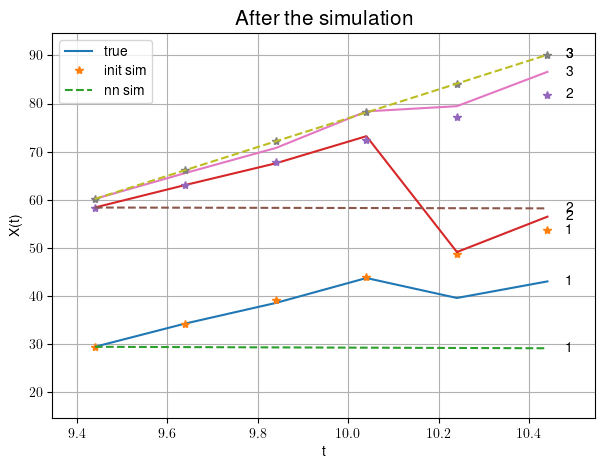

In [22]:
# Params
N = scn['N. vehicles']
t0, tf = tstamps[0], tstamps[-1]
trajs = [scn['Xarr'],sol_matched, y_ann]
labels_plot = ["true","init sim","nn sim"]
title = f"After the simulation"

# fig 
width, height = 7, 5
fig, ax = plt.subplots(figsize=(width,height))

for veh in range(0,N):
    ax.plot(tstamps, trajs[0][veh])
    ax.plot(tspan[::factor], trajs[1][veh], '*')
    ax.plot(tspan[::factor], y_ann[veh], '--')


# Annotate the name of each variable at the last value§
scale = 1.004
labels = list(range(1,N+1,1))
for ycoord in trajs:
    coords = zip([tf*scale]*N,ycoord[:,-1]) # last value where I want to annotate the corresponding label
    for coord,lab in zip(coords,labels):
        ax.annotate(xy=coord,                    # The point (x, y) to annotate.
                    xytext=coord,                # The position (x, y) to place the text at.
    #                 textcoords='offset points',
                    text=lab,
                    verticalalignment='center')


ax.set_xlabel("t")
ax.set_ylabel("X(t)")
ax.set_title(title, fontsize=15)
# X LIM
xbal = 0.01
ax.set_xlim(tstamps[0]*(1-xbal), tstamps[-1]*(1+xbal))
# Y LIM
ybal = 0.05
mmin, mmax = min([x.min() for x in trajs]), max([x.max() for x in trajs])
ax.set_ylim(mmin*(1-10*ybal), mmax*(1+ybal))
plt.legend(labels_plot)
plt.grid()
plt.show()